In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.enable_validation(True)

import matplotlib.pyplot as plt

### Importing the grid search results from the simulator

In [2]:
file_path = "gem5-aladdin_data/stencil_stencil3d_results.csv"
results_df = pd.read_csv(file_path, delimiter=",").drop_duplicates()

In [3]:
results_df.columns

Index(['tlb_page_size', 'tlb_entries', 'tlb_assoc', 'cycle_time',
       'tlb_max_outstanding_walks', 'tlb_miss_latency', 'cache_line_sz',
       'cache_assoc', 'cache_queue_size', 'tlb_hit_latency', 'pipelined_dma',
       'cache_size', 'pipelining', 'cache_hit_latency', 'cache_bandwidth',
       'tlb_bandwidth', 'success', 'cycle', 'power', 'area'],
      dtype='object')

In [4]:
X_data_np = results_df[['tlb_page_size', 'tlb_entries', 'tlb_assoc', 'cycle_time',
       'tlb_max_outstanding_walks', 'tlb_miss_latency', 'cache_line_sz',
       'cache_assoc', 'cache_queue_size', 'tlb_hit_latency', 'pipelined_dma',
       'cache_size', 'pipelining', 'cache_hit_latency', 'cache_bandwidth',
       'tlb_bandwidth']].values.astype(np.float32)

y_data_np = results_df['power'].values.astype(np.float32)

In [5]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_data_np, 
                                                                y_data_np, test_size=0.33, random_state=42)

### Converting numpy arrays to torch tensors

In [6]:
X_train = torch.tensor(X_train_np)
X_test = torch.tensor(X_test_np)
y_train = torch.tensor(y_train_np)
y_test = torch.tensor(y_test_np)

# Neural Network

A simple feed forward neural network

In [7]:
class FFNet(nn.Module):

    def __init__(self):
        super(FFNet, self).__init__()
        
        self.input_ch = 16
        self.output_ch = 1
        
        ######## Hidden layers ########
        
        #   linear functions
        self.lf1_output_ch = 200
        self.lf1 = nn.Linear(self.input_ch, self.lf1_output_ch)
        
        self.lf2_output_ch = 100
        self.lf2 = nn.Linear(self.lf1_output_ch, self.lf2_output_ch)
        
        self.lf3_output_ch = 50
        self.lf3 = nn.Linear(self.lf2_output_ch, self.lf3_output_ch)
        
#         self.lf4_output_ch = 50
#         self.lf4 = nn.Linear(self.lf3_output_ch, self.lf4_output_ch)
        
#         self.lf5_output_ch = 50
#         self.lf5 = nn.Linear(self.lf4_output_ch, self.lf5_output_ch)
        
#         self.lf6_output_ch = 50
#         self.lf6 = nn.Linear(self.lf5_output_ch, self.lf6_output_ch)
        
#         self.lf7_output_ch = 25
#         self.lf7 = nn.Linear(self.lf6_output_ch, self.lf7_output_ch)
        
#         self.lf8_output_ch = 25
#         self.lf8 = nn.Linear(self.lf7_output_ch, self.lf8_output_ch)
        
#         self.lf9_output_ch = 25
#         self.lf9 = nn.Linear(self.lf8_output_ch, self.lf9_output_ch)
        
        self.lf10_output_ch = 25
        self.lf10 = nn.Linear(self.lf3_output_ch, self.lf10_output_ch)
        
        #   linear function
        self.lff = nn.Linear(self.lf10_output_ch, self.output_ch)
        
        ######## Functions ########
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, X):
        
        out = self.lf1(X)
        out = self.sigmoid(out)
        out = self.lf2(out)
        out = self.sigmoid(out)
        out = self.lf3(out)
        #out = self.relu(out)
        out = self.lf10(out)
        #out = self.relu(out)
        out = self.lff(out)
        #out = self.relu(out)
        
        return out

    def intermediate_results(self, X):
        
        out = self.lf1(X)
        out = self.sigmoid(out)
        out = self.lf2(out)
        out = self.sigmoid(out)
        out = self.lf3(out)
        #out = self.relu(out)
        out = self.lf10(out)
        out = self.relu(out)
        
        return out
        

# Training

In [8]:
ffnet_model = FFNet()
optimizer = torch.optim.Adam(ffnet_model.parameters(), lr=0.00001)
criterion = nn.MSELoss()

In [9]:
# Sets the module in training mode.
ffnet_model.train()

num_epochs = 10000

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = ffnet_model(X_train)
    
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
    
    if ((epoch+1) % ((num_epochs) * 0.1) == 0) or (epoch == 0):
        print('Epoch {} {}%: train loss: {}'.format(epoch+1, (epoch+1)/num_epochs*100,loss.item()))
    
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 1 0.01%: train loss: 331.3376159667969
Epoch 1000 10.0%: train loss: 251.75296020507812
Epoch 2000 20.0%: train loss: 148.73500061035156
Epoch 3000 30.0%: train loss: 139.19857788085938
Epoch 4000 40.0%: train loss: 136.2516326904297
Epoch 5000 50.0%: train loss: 129.01182556152344
Epoch 6000 60.0%: train loss: 117.78350830078125
Epoch 7000 70.0%: train loss: 108.6906509399414
Epoch 8000 80.0%: train loss: 103.12548065185547
Epoch 9000 90.0%: train loss: 99.74620819091797
Epoch 10000 100.0%: train loss: 97.65202331542969


# Testing

In [10]:
# Sets the module in evulation mode.
ffnet_model.eval()

y_pred = ffnet_model(X_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

Test loss after Training 119.84960174560547


In [11]:
from random import randrange
num = randrange(len(y_test))
print(num, y_pred.squeeze()[num], y_test[num])

167 tensor(7.6854, grad_fn=<SelectBackward>) tensor(16.5605)


# Testing GPs with NN

### The GP

In [12]:
pyro.clear_param_store()
with torch.no_grad():
    ffnet_model.eval()
    nn_gp_X_train = ffnet_model.intermediate_results(X_test)
    nn_gp_y_train = y_test

nn_gp_kernel = gp.kernels.Matern52(input_dim=ffnet_model.lf10_output_ch, 
                                lengthscale=50*torch.ones(ffnet_model.lf10_output_ch))


nn_gp = gp.models.GPRegression(nn_gp_X_train, nn_gp_y_train, nn_gp_kernel)

nn_gp.kernel.lengthscale = 15*torch.ones(ffnet_model.lf10_output_ch)
nn_gp.kernel.variance = torch.tensor(50.0)
nn_gp.kernel.noise = torch.tensor(0.01)
nn_gp.kernel.jitter=1.0e-4

In [13]:
optimizer = torch.optim.Adam(nn_gp.parameters(), lr=0.01)

In [14]:
losses = gp.util.train(nn_gp, optimizer, num_steps=4000)

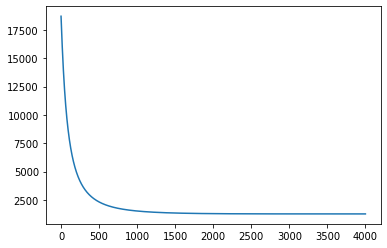

In [15]:
plt.plot(losses);

### Comparison

#### NN

In [16]:
nn_predict = ffnet_model(X_test)
nn_criterion = criterion(nn_predict.squeeze(), y_test) 
print(nn_criterion)

tensor(119.8496, grad_fn=<MseLossBackward>)


#### NN + GP

In [17]:
nn_gp_predict = nn_gp(ffnet_model.intermediate_results(X_test))
norm_dist = dist.Normal(nn_gp_predict[0], nn_gp_predict[1])
norm_dist_sample = norm_dist.sample()
nn_gp_criterion = criterion(norm_dist_sample.squeeze(), y_test) 

print(nn_gp_criterion)

tensor(113.1515)
